In [11]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import lime
import lime.lime_tabular

from sklearn import preprocessing 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from googletrans import Translator, LANGUAGES  
from deep_translator import GoogleTranslator 
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.metrics import roc_auc_score


#Classifier imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import StackingClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

#Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, message="Glyph 9 missing from current font")
warnings.filterwarnings('ignore') 

#Set option to expand DataFrame representation
pd.set_option("expand_frame_repr", False)

In [3]:
#Phase 1
#Add in Translated languages to Original Lexicon Dataset
file_path = 'Lexicon_Dataset_Original.xlsx'
df = pd.read_excel(file_path)
print('Original Lexicon Dataset')
print(df.head(10))

#Define translation columns
languages = {
    'ENGLISH': 'en',
    'SHONA': 'sn',
    'SePEDI': 'nso',
    'SeSOTHO': 'st',
    'IsiZULU': 'zu'
}

#Initialize the Google Translator for French source language
source_language = 'fr'

#Add columns for each target language with translations
for lang_name, lang_code in languages.items():
    translated_words = []
    for word in df['FRANCAIS']:
        try:
            translated = GoogleTranslator(source=source_language, target=lang_code).translate(word)
            translated_words.append(translated)
        except Exception as e:
            translated_words.append("") 
    df[lang_name] = translated_words

#Reorder columns
df = df[['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI',  'SeSOTHO', 'IsiZULU','SCORE','SENTIMENT', 'NATURE']]

#Save the updated DataFrame
output_file_path = 'Lexicon_Dataset_v3.xlsx'
df.to_excel(output_file_path, index=False)
print("Translation completed and saved to")

Translation completed and saved to


In [5]:
#Phase 2 Load the datasets
#Words Dataset
lexicon_path = r'Lexicon_Dataset_v3.xlsx'
df_lexicon = pd.read_excel(lexicon_path)
print('Word Dataset Details')
print(df_lexicon.head(10))

#Sentence Dataset
sentence_path = r'Sentences_Dataset.xlsx'
df_sen = pd.read_excel(sentence_path)
df_sen.columns = ['Sentences'] 
print('Sentence Dataset Details') 
print(df_sen)

Word Dataset Details
      CILUBA    FRANCAIS      English           Shona              Sepedi             SeSotho            IsiZulu  SCORE SENTIMENT NATURE
0      Akaja     Arrange      Arrange           Ronga            Beakanya            Hlophisa              Hlela      1   Positif  Verbe
1  Akajilula   Rearrange    Rearrange      Rear range      Morao fapaneng  Sebaka se ka morao  Ibanga elingemuva      1   Positif  Verbe
2      Akula       Parle        Speak           Taura              Bolela                 Bua            Khuluma      2   Positif  Verbe
3    Akulula     Reparle  Speak again   Taura zvakare         Bolela gape            Bua hape      Khuluma futhi      2   Positif  Verbe
4      Aluja       Remet       Return  Maoko pamusoro    Matsogo a godimo          Ka matsoho      Izandla phezu      3   Positif  Verbe
5       Amba         Dis          Say             Say              Bolela                 Bua               Isho      3   Positif  Verbe
6   Ambakaja  Supper

In [6]:
#View Data Details
#Words Dataset
print('Word Dataset Details')
df_lexicon.info()
df_lexicon.describe() 

#Sentence Dataset
print('Sentence Dataset Details')
df_sen.info()
df_sen.describe() 

Word Dataset Details
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CILUBA     2999 non-null   object
 1   FRANCAIS   2999 non-null   object
 2   English    2999 non-null   object
 3   Shona      2999 non-null   object
 4   Sepedi     2999 non-null   object
 5   SeSotho    2999 non-null   object
 6   IsiZulu    2999 non-null   object
 7   SCORE      3000 non-null   int64 
 8   SENTIMENT  3000 non-null   object
 9   NATURE     3000 non-null   object
dtypes: int64(1), object(9)
memory usage: 234.5+ KB
Sentence Dataset Details
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentences  5 non-null      object
dtypes: object(1)
memory usage: 172.0+ bytes


,Sentences
count,5
unique,5
top,"Friendship, laughter, and hope bring joy and ..."
freq,1


In [6]:
#Phase 3 Clean Data 
#Ensure columns are named correctly
df_lexicon.columns = ['CILUBA', 'FRANCAIS', 'ENGLISH','SHONA','SePEDI', 'SeSOTHO', 'IsiZULU', 'SCORE', 'SENTIMENT', 'NATURE']
print("Loaded columns in Lexicon Dataset:", df_lexicon.columns.tolist())

#Clean text data by removing non-printable characters
for col in ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI','SeSOTHO', 'IsiZULU',  'SENTIMENT', 'NATURE']:
    if col in df_lexicon.columns:
        df_lexicon[col] = df_lexicon[col].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

#Fill any missing values with empty strings
df_lexicon = df_lexicon.fillna('')

#Clean SENTIMENT by translating non-English words to English
if isinstance(df_lexicon, list):
    df_lexicon = pd.DataFrame(df_lexicon)
if isinstance(df_lexicon['SENTIMENT'], list):
    df_lexicon['SENTIMENT'] = pd.Series(df_lexicon['SENTIMENT'])
sentiment_mapping = {
    'Positif': 'Positive',
    'Négatif': 'Negative',
    'Neutre': 'Neutral'
}
df_lexicon['SENTIMENT'] = df_lexicon['SENTIMENT'].replace(sentiment_mapping)

#Clean NATURE by translating non-English words to English
if isinstance(df_lexicon, list):
    df_lexicon = pd.DataFrame(df_lexicon)
if isinstance(df_lexicon['NATURE'], list):
    df_lexicon['NATURE'] = pd.Series(df_lexicon['NATURE'])
sentiment_mapping = {
    'adjectif': 'Adjective',
    'Adverbe': 'Adverb',
    'Article': 'Article',
    'Conjoction': 'Conjunction',
    'Mot': 'Word',
    'Nombre': 'Number',
    'pronompersonnel': 'Pronoun',
    'Verbe': 'Verb'
}
df_lexicon['NATURE'] = df_lexicon['NATURE'].replace(sentiment_mapping)

#Clean sentences by removing punctuation
for index, row in df_sen.iterrows():
    sentence = row['Sentences']
    cleaned_sentence = re.sub(r'[^\w\s]', '', sentence)
    df_sen.at[index, 'Sentences'] = cleaned_sentence


print(df_lexicon)
print(df_sen)

Loaded columns in Lexicon Dataset: ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU', 'SCORE', 'SENTIMENT', 'NATURE']
         CILUBA    FRANCAIS      ENGLISH           SHONA            SePEDI             SeSOTHO            IsiZULU  SCORE SENTIMENT       NATURE
0         Akaja     Arrange      Arrange           Ronga          Beakanya            Hlophisa              Hlela      1  Positive         Verb
1     Akajilula   Rearrange    Rearrange      Rear range    Morao fapaneng  Sebaka se ka morao  Ibanga elingemuva      1  Positive         Verb
2         Akula       Parle        Speak           Taura            Bolela                 Bua            Khuluma      2  Positive         Verb
3       Akulula     Reparle  Speak again   Taura zvakare       Bolela gape            Bua hape      Khuluma futhi      2  Positive         Verb
4         Aluja       Remet       Return  Maoko pamusoro  Matsogo a godimo          Ka matsoho      Izandla phezu      3  Positive        

In [57]:
#Phase 4 Testing Translation Functionality
#Translation and Scoring Dictionaries
translation_lexique = {}
language_columns = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU']
for lang in language_columns:
    if lang in df_lexicon.columns:
        for index, row in df_lexicon.iterrows():
            word = row[lang].lower()
            translation_lexique[word] = {col: row[col].lower() for col in language_columns if col in df_lexicon.columns and col != lang}

#Scoring dictionary setup
lexique = {lang: dict(zip(df_lexicon[lang].str.lower(), df_lexicon['SCORE'])) for lang in language_columns}

#Function to translate text
def translate_text_using_lexicon(text, source_language='ENGLISH', target_language='FRANCAIS'):
    words = text.lower().split()
    translated_words = [translation_lexique.get(word, {}).get(target_language, f"[{word}]") for word in words]
    return ' '.join(translated_words)

#Function to analyze sentiment
def analyse_sentiment(text, language):
    language_lexique = lexique.get(language, {})
    words = text.lower().split()
    word_scores = {word: language_lexique.get(word, 0) for word in words}
    score = sum(word_scores.values())
    sentiment = "Positive" if score > 0.05 else ("Negative" if score < -0.05 else "Neutral")
    return score, sentiment, word_scores

#Main analysis loop
sentiment_analysis_results = []
for idx, row in df_sen.iterrows():
    sentence = row['Sentences']
    
    # Translate to different languages
    translations = {
        lang: translate_text_using_lexicon(sentence, 'ENGLISH', lang.upper())
        for lang in ['FRANCAIS', 'CILUBA', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU']
    }

    #Perform sentiment analysis for each translation
    for lang, translated_text in translations.items():
        total_score, sentiment, word_scores = analyse_sentiment(translated_text, language=lang.upper())
        
        # Collect the result
        sentiment_analysis_results.append({
            'Original Sentence': sentence,
            'Language': lang,
            'Translation': translated_text,
            'Total Score': total_score,
            'Predicted Sentiment': sentiment,
            'Word Scores': word_scores
        })

# Convert to DataFrame for viewing
df_sentiment_analysis_results = pd.DataFrame(sentiment_analysis_results)
# tools.display_dataframe_to_user(name="Detailed Sentiment Analysis Results", dataframe=df_sentiment_analysis_results)

display(df_sentiment_analysis_results)

,Original Sentence,Language,Translation,Total Score,Predicted Sentiment,Word Scores
0,Friendship laughter and hope bring joy and li...,FRANCAIS,amiti [laughter] et esprance apporter allgress...,25,Positive,"{'amiti': 3, '[laughter]': 0, 'et': 0, 'espran..."
1,Friendship laughter and hope bring joy and li...,CILUBA,bulunda [laughter] ni kutekemena: kumupetesha ...,32,Positive,"{'bulunda': 3, '[laughter]': 0, 'ni': 0, 'kute..."
2,Friendship laughter and hope bring joy and li...,SHONA,ushamwari [laughter] uye [hope] [bring] [joy] ...,14,Positive,"{'ushamwari': 3, '[laughter]': 0, 'uye': 0, '[..."
3,Friendship laughter and hope bring joy and li...,SePEDI,[friendship] [laughter] [and] [hope] [bring] [...,0,Neutral,"{'[friendship]': 0, '[laughter]': 0, '[and]': ..."
4,Friendship laughter and hope bring joy and li...,SeSOTHO,[friendship] [laughter] [and] [hope] [bring] [...,0,Neutral,"{'[friendship]': 0, '[laughter]': 0, '[and]': ..."
5,Friendship laughter and hope bring joy and li...,IsiZULU,[friendship] [laughter] [and] [hope] [bring] [...,0,Neutral,"{'[friendship]': 0, '[laughter]': 0, '[and]': ..."
6,People walk between light and shadow finding ...,FRANCAIS,lesgens marche entre lumire et ombre [finding]...,25,Positive,"{'lesgens': 4, 'marche': 3, 'entre': 3, 'lumir..."
7,People walk between light and shadow finding ...,CILUBA,bantu enda buela butooka ni ditalalaji [findin...,26,Positive,"{'bantu': 4, 'enda': 3, 'buela': 7, 'butooka':..."
8,People walk between light and shadow finding ...,SHONA,vanhu famba [between] chiedza uye [shadow] [fi...,18,Positive,"{'vanhu': 4, 'famba': 3, '[between]': 0, 'chie..."
9,People walk between light and shadow finding ...,SePEDI,[people] [walk] [between] [light] [and] [shado...,0,Neutral,"{'[people]': 0, '[walk]': 0, '[between]': 0, '..."


CILUBA
FRANCAIS
ENGLISH
SHONA
SePEDI
SeSOTHO
IsiZULU
SCORE
SENTIMENT
NATURE


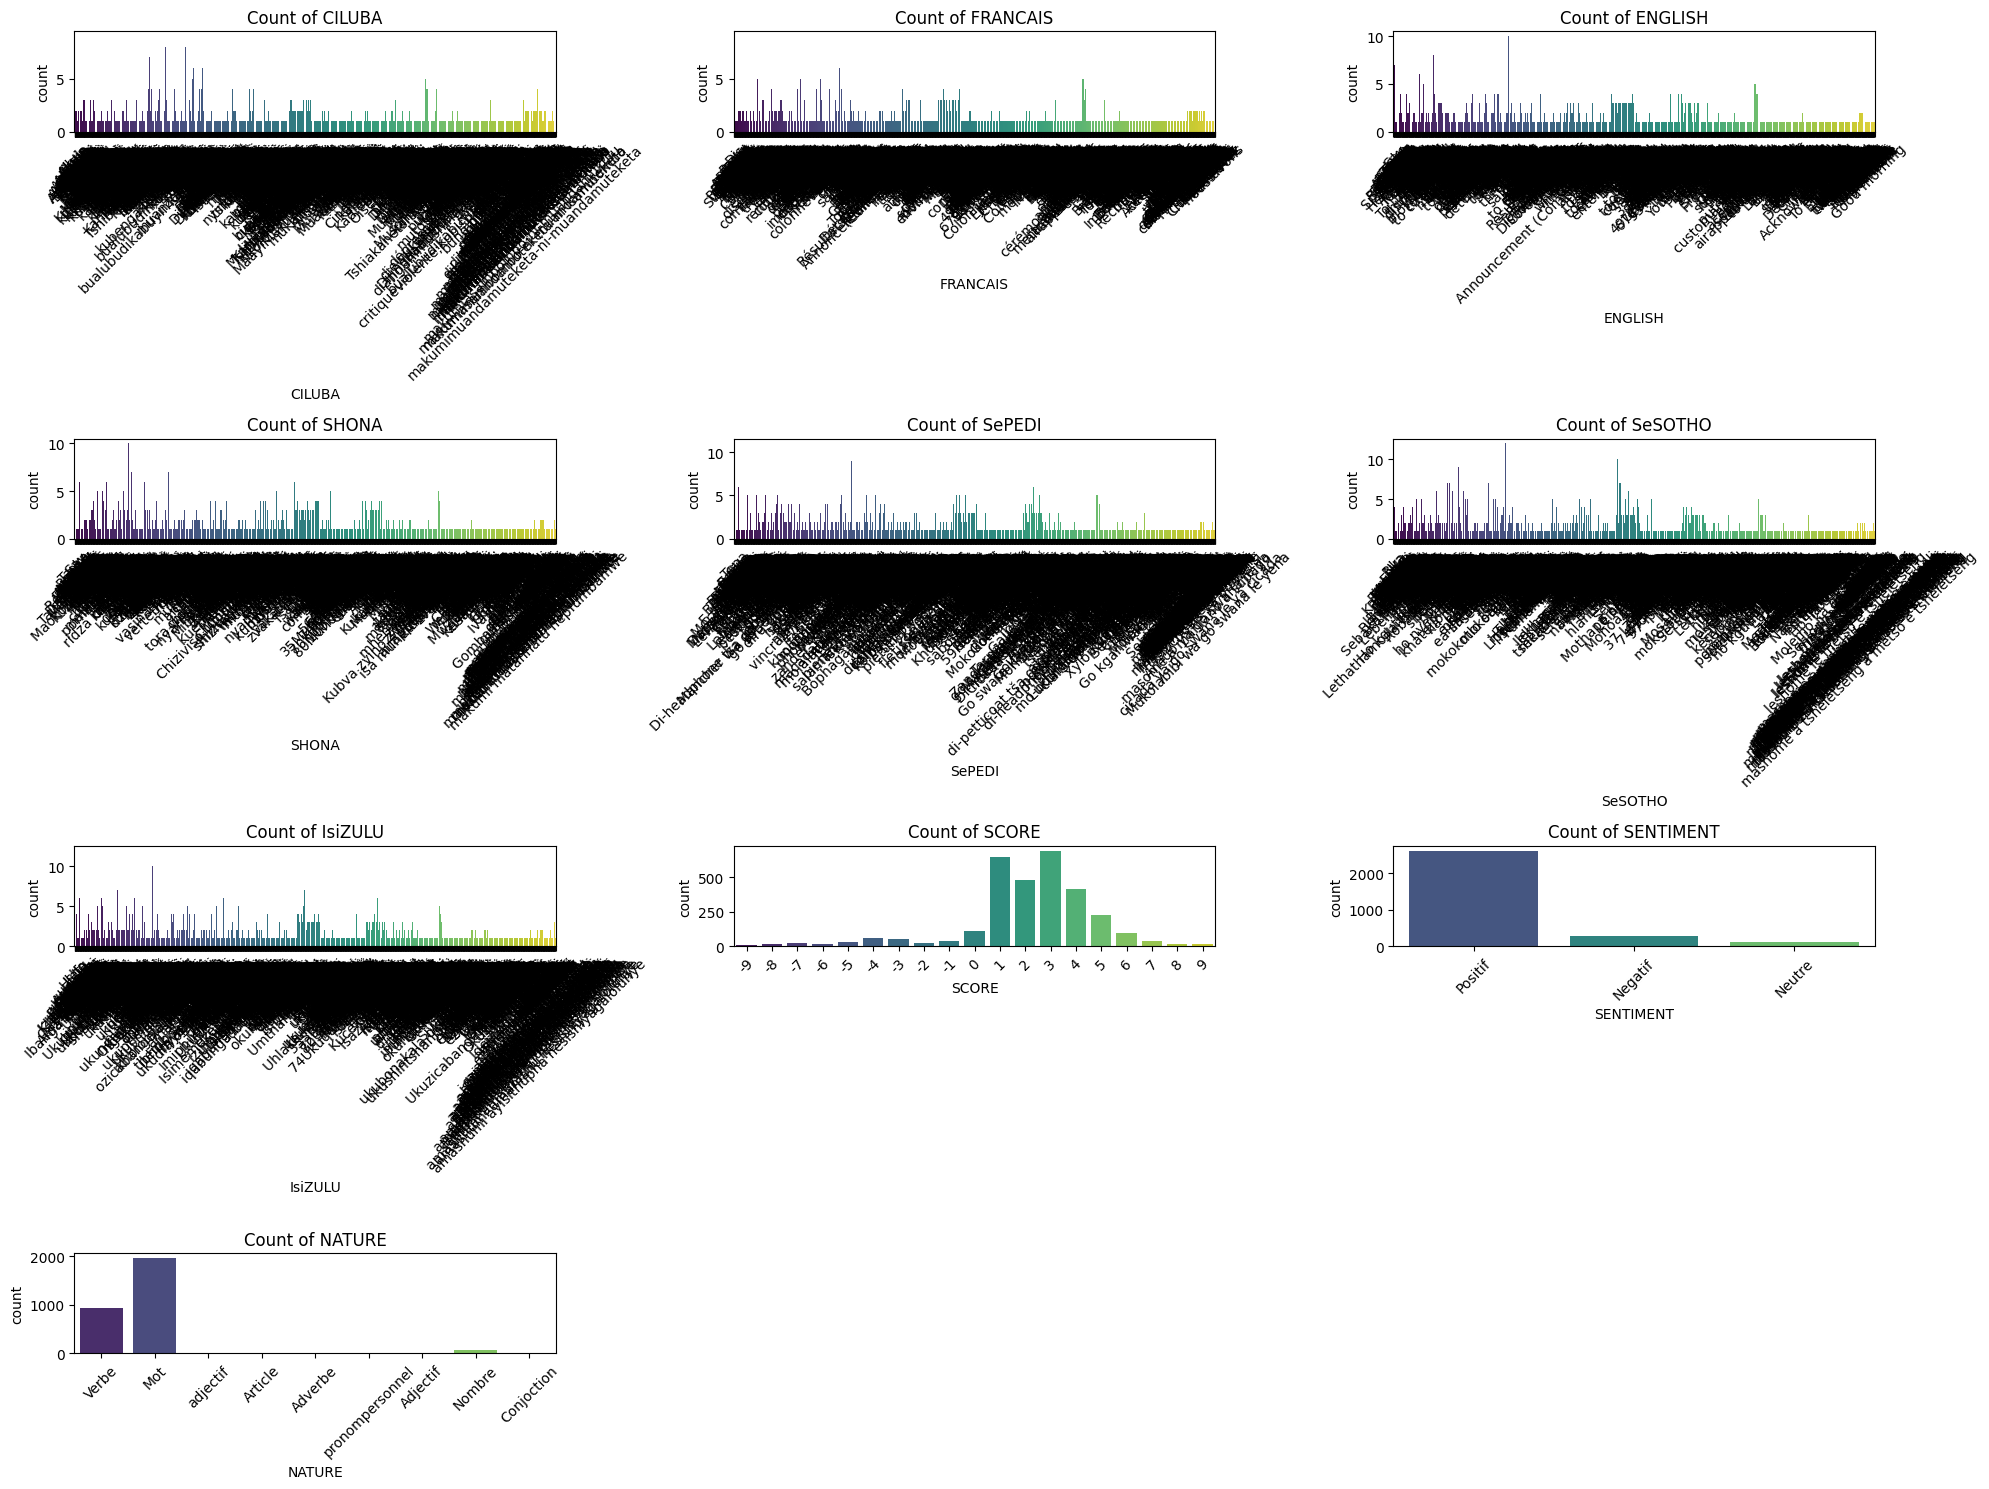

In [13]:
#Load the dataset
file_path = 'Lexicon_Dataset_v3.xlsx'  
df = pd.read_excel(file_path)

#Ensure columns are named correctly
df.columns = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI',  'SeSOTHO', 'IsiZULU', 'SCORE', 'SENTIMENT', 'NATURE']

plt.figure(figsize=(20, 15))

for i, column in enumerate(df.columns):
    print(column)
    plt.subplot(4, 3, i + 1)  # Adjusted to a 4x3 grid to fit 10 subplots
    sns.countplot(data=df, x=column, palette='viridis')
    plt.title(f'Count of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


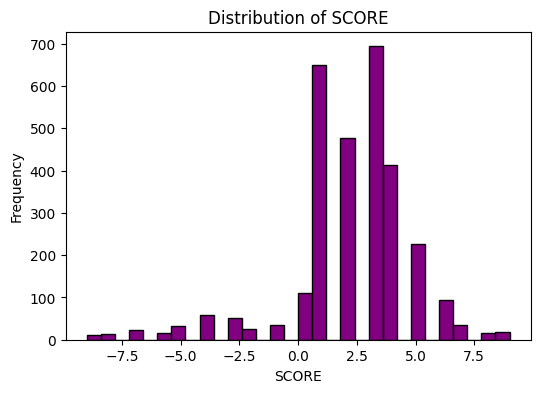

SCORE   -1.241045
dtype: float64


In [14]:
#Phase 4 Transform Numerical Data
numerical_data = df_lexicon.select_dtypes(include=['int64']).columns
skewness = df_lexicon[numerical_data].skew()

for data in numerical_data:
    plt.figure(figsize=(6, 4))
    plt.hist(df_lexicon[data], bins=30, edgecolor='k', color='purple')
    plt.title(f'Distribution of {data}')
    plt.xlabel(data)
    plt.ylabel('Frequency')
    plt.show()

# Display the skewness values
print(skewness)

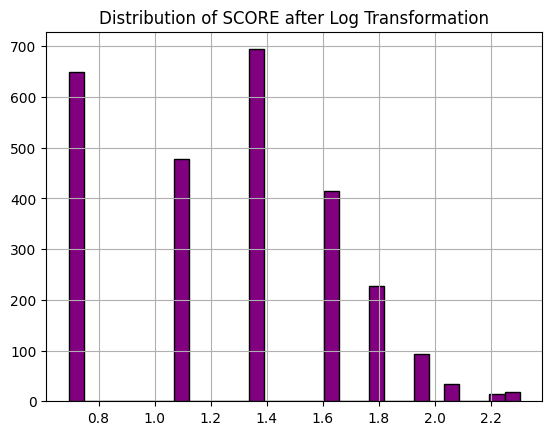

Distribution of SCORE after Log Transformation = -0.010798310496977088
         CILUBA   FRANCAIS      ENGLISH           SHONA            SePEDI             SeSOTHO            IsiZULU  SCORE SENTIMENT  NATURE  SCORE_log_transformation
0         Akaja    Arrange      Arrange           Ronga          Beakanya            Hlophisa              Hlela      1  Positive    Verb                  0.693147
1     Akajilula  Rearrange    Rearrange      Rear range    Morao fapaneng  Sebaka se ka morao  Ibanga elingemuva      1  Positive    Verb                  0.693147
2         Akula      Parle        Speak           Taura            Bolela                 Bua            Khuluma      2  Positive    Verb                  1.098612
3       Akulula    Reparle  Speak again   Taura zvakare       Bolela gape            Bua hape      Khuluma futhi      2  Positive    Verb                  1.098612
4         Aluja      Remet       Return  Maoko pamusoro  Matsogo a godimo          Ka matsoho      Izandla ph

In [7]:
#Log transformation of SCORE to fix the right skewness 
#Remove rows with SCORE <= 0 to avoid log(0) or log of negative numbers
df_lexicon = df_lexicon[df_lexicon['SCORE'] > 0]

#Log transformation 
df_lexicon['SCORE_log_transformation'] = np.log(df_lexicon['SCORE'] + 1)

df_lexicon['SCORE_log_transformation'].hist(bins=30, edgecolor='k', color='purple')
plt.title('Distribution of SCORE after Log Transformation')
plt.show()

skewness = df_lexicon['SCORE_log_transformation'].skew()
print('Distribution of SCORE after Log Transformation =', skewness)
print(df_lexicon)

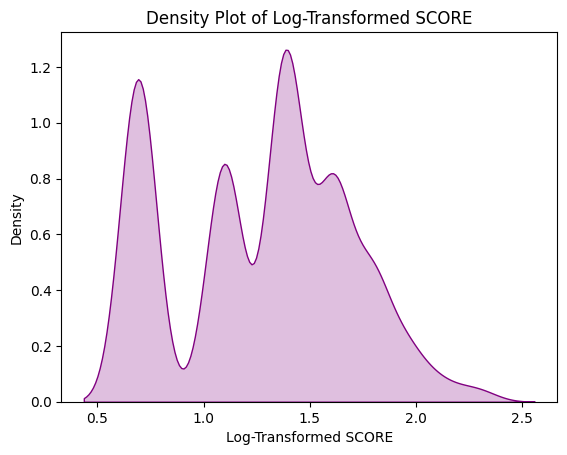

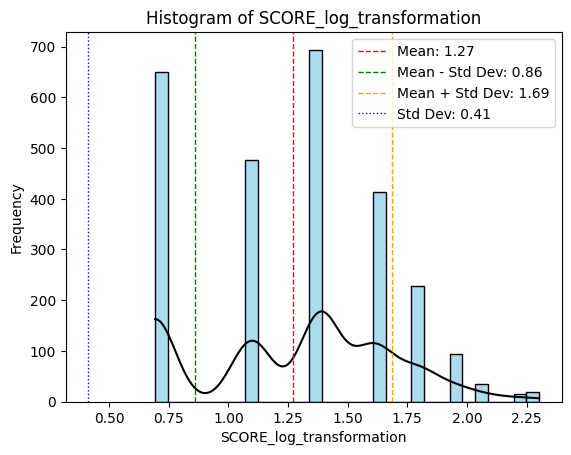

In [47]:
#Phase 5 Data Visualization 
#Visualize the Score
#Density Plot
sns.kdeplot(df_lexicon['SCORE_log_transformation'], fill=True, color="purple")
plt.title('Density Plot of Log-Transformed SCORE')
plt.xlabel('Log-Transformed SCORE')
plt.ylabel('Density')
plt.show()

#Histogram Plot
feature = 'SCORE_log_transformation'
data = df_lexicon[feature]
mean = np.mean(data)
std_dev = np.std(data)

ax = sns.histplot(data, bins=30, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
ax.lines[0].set_color('black')

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean - Std Dev: {mean - std_dev:.2f}')
plt.axvline(mean + std_dev, color='orange', linestyle='dashed', linewidth=1, label=f'Mean + Std Dev: {mean + std_dev:.2f}')
plt.axvline(std_dev, color='blue', linestyle='dotted', linewidth=1, label=f'Std Dev: {std_dev:.2f}')

plt.legend(loc='upper right')

plt.title(f'Histogram of {feature}')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.show()

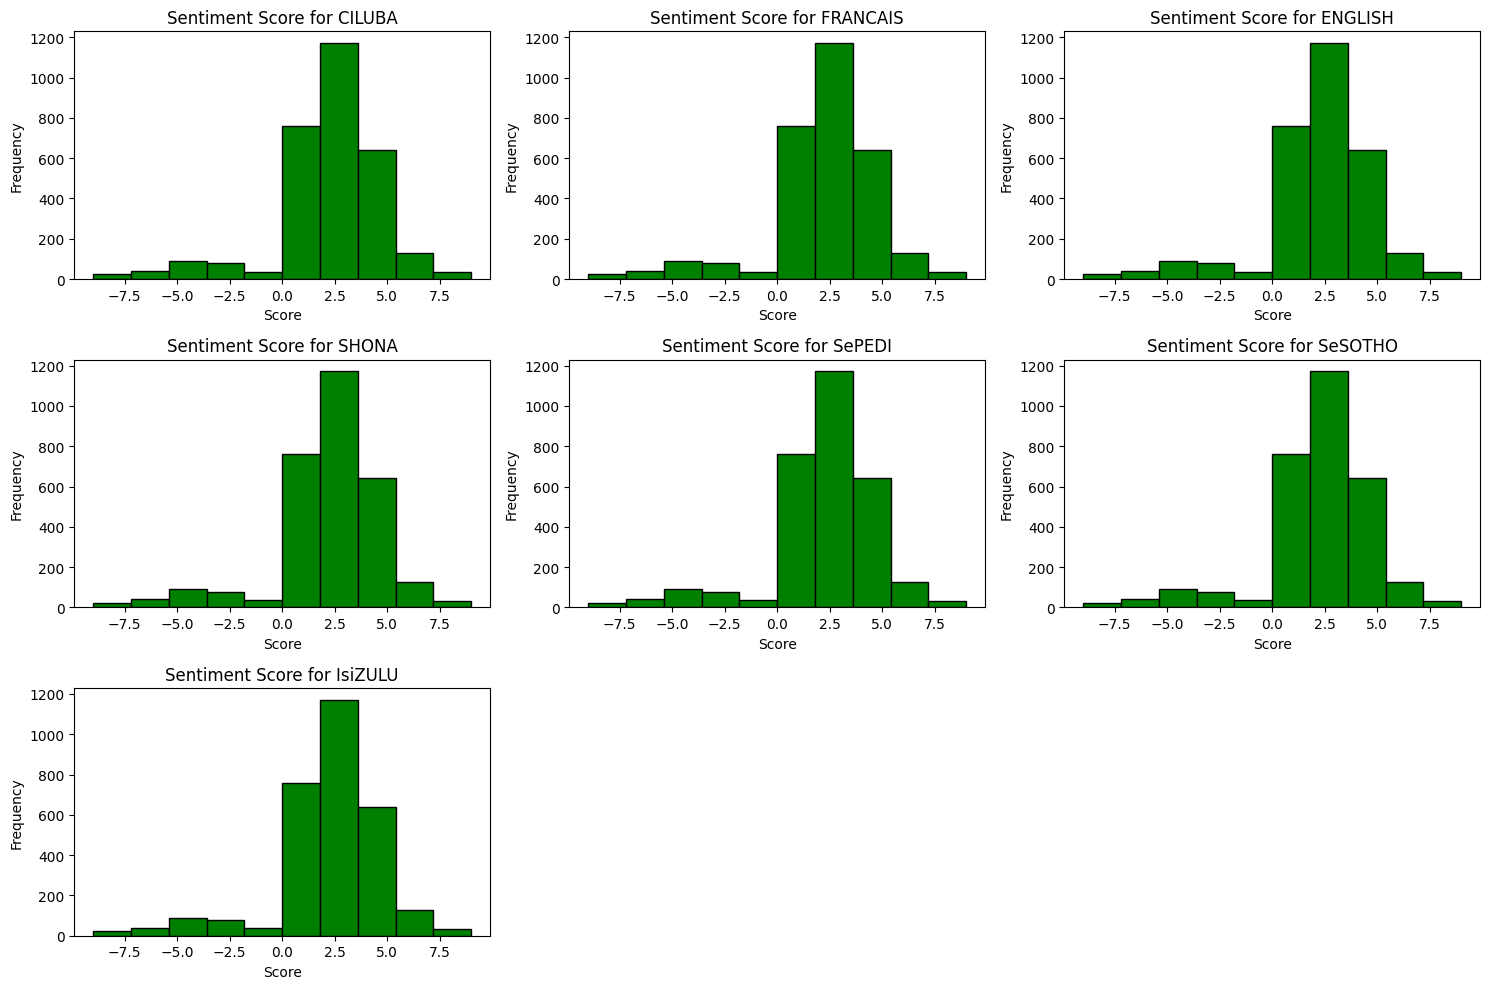

In [48]:
# # Load the dataset
# file_path = 'Lexicon_Dataset_v3.xlsx'  
# df = pd.read_excel(file_path)

# Ensure columns are named correctly
df_lexicon.columns = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU', 'SCORE', 'SENTIMENT', 'NATURE','SCORE_log_transformation']

# Define the languages for which we want to visualize sentiment scores
languages = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU']

# Plot histograms for each language's sentiment score
plt.figure(figsize=(15, 10))


 
for i, language in enumerate(languages):
    plt.subplot(3, 3, i + 1)
    plt.hist(df['SCORE'], bins=10, color='green', edgecolor='black')
    plt.title(f'Sentiment Score for {language}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


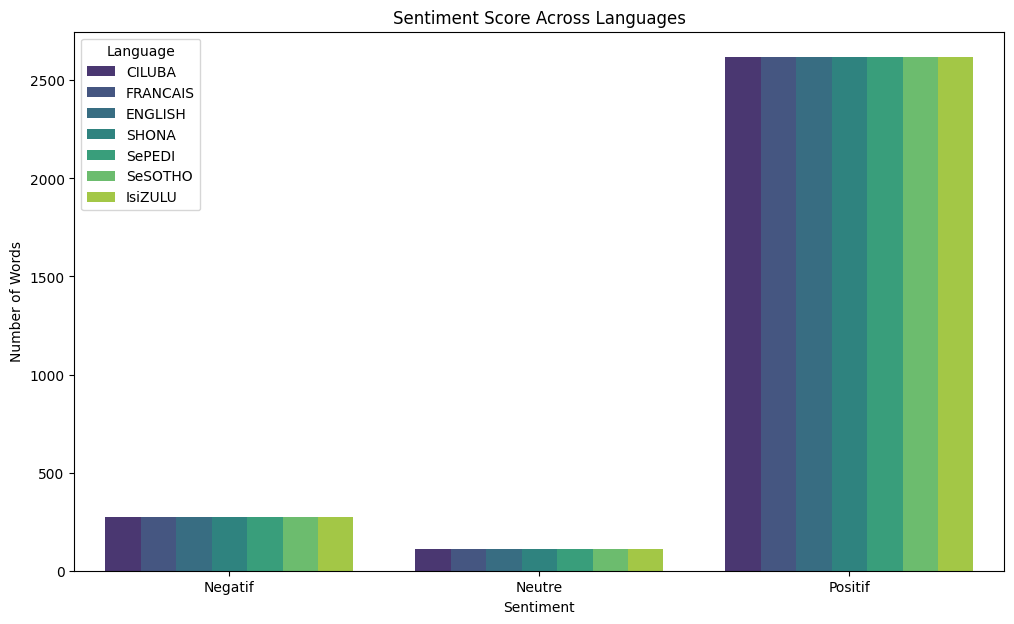

In [49]:
#Ensure columns are named correctly
df_lexicon.columns = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU', 'SCORE', 'SENTIMENT', 'NATURE', 'SCORE_log_transformation']

# Define the languages for which we want to visualize sentiment scores
languages = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU']

# Prepare data for plotting by counting words for each language and sentiment
data = []
for language in languages:
    word_counts = df.groupby('SENTIMENT')[language].count().reset_index()
    word_counts.columns = ['Sentiment', 'Word Count']
    word_counts['Language'] = language
    data.append(word_counts)

# Concatenate all the individual language data into a single DataFrame
df_plot = pd.concat(data, ignore_index=True)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(data=df_plot, x='Sentiment', y='Word Count', hue='Language', palette='viridis')

# Adding title and labels
plt.title("Sentiment Score Across Languages")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")

# Display plot with legend
plt.legend(title='Language')
plt.show()


In [8]:
#Phase 6 Prepare data for machine learning models
#OBJECTIVE to prepare data for a machine learning classification model to predict the sentiment of words based on their nature and score

#Encode the 'SENTIMENT' and 'NATURE' columns into numerical labels
label_encoder_SENTIMENT = LabelEncoder()
df_lexicon['SENTIMENT_encoded'] = label_encoder_SENTIMENT.fit_transform(df_lexicon['SENTIMENT'])

label_encoder_NATURE = LabelEncoder()
df_lexicon['NATURE_encoded'] = label_encoder_NATURE.fit_transform(df_lexicon['NATURE'])


print(df_lexicon)

         CILUBA   FRANCAIS      ENGLISH           SHONA            SePEDI             SeSOTHO            IsiZULU  SCORE SENTIMENT  NATURE  SCORE_log_transformation  SENTIMENT_encoded  NATURE_encoded
0         Akaja    Arrange      Arrange           Ronga          Beakanya            Hlophisa              Hlela      1  Positive    Verb                  0.693147                  1               1
1     Akajilula  Rearrange    Rearrange      Rear range    Morao fapaneng  Sebaka se ka morao  Ibanga elingemuva      1  Positive    Verb                  0.693147                  1               1
2         Akula      Parle        Speak           Taura            Bolela                 Bua            Khuluma      2  Positive    Verb                  1.098612                  1               1
3       Akulula    Reparle  Speak again   Taura zvakare       Bolela gape            Bua hape      Khuluma futhi      2  Positive    Verb                  1.098612                  1               1
4    

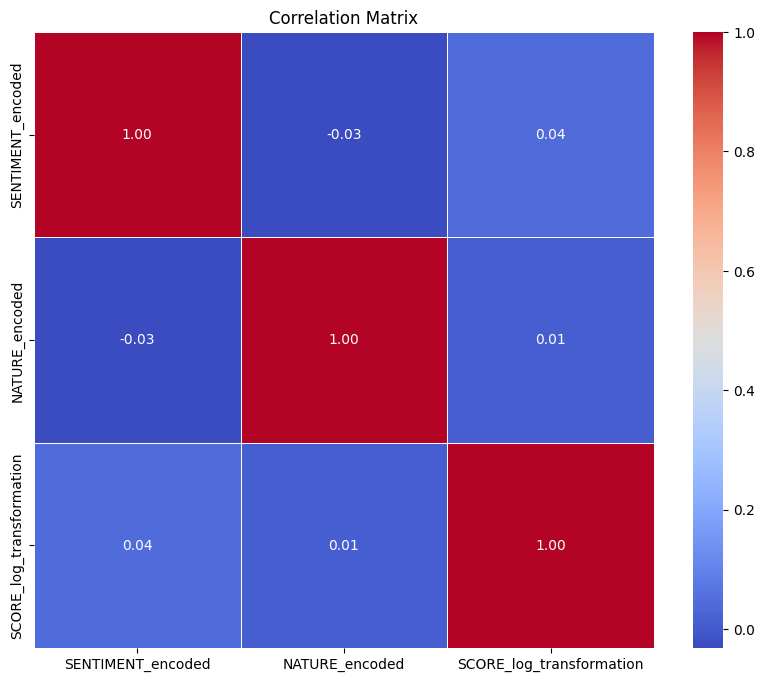

In [9]:
#Visualise the Correlation Matrix
selected_columns = ['SENTIMENT_encoded', 'NATURE_encoded', 'SCORE_log_transformation']
selected_data = df_lexicon[selected_columns]

#Create the correlation matrix
corr_matrix = selected_data.corr()

#Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


=== Random Forest ===

Accuracy: 1.00
Precision: 1.00
Recall: 1.00

Classification Report:
               precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         1
     Positif       1.00      1.00      1.00       524

    accuracy                           1.00       525
   macro avg       0.50      0.50      0.50       525
weighted avg       1.00      1.00      1.00       525

ROC-AUC Score: 0.36


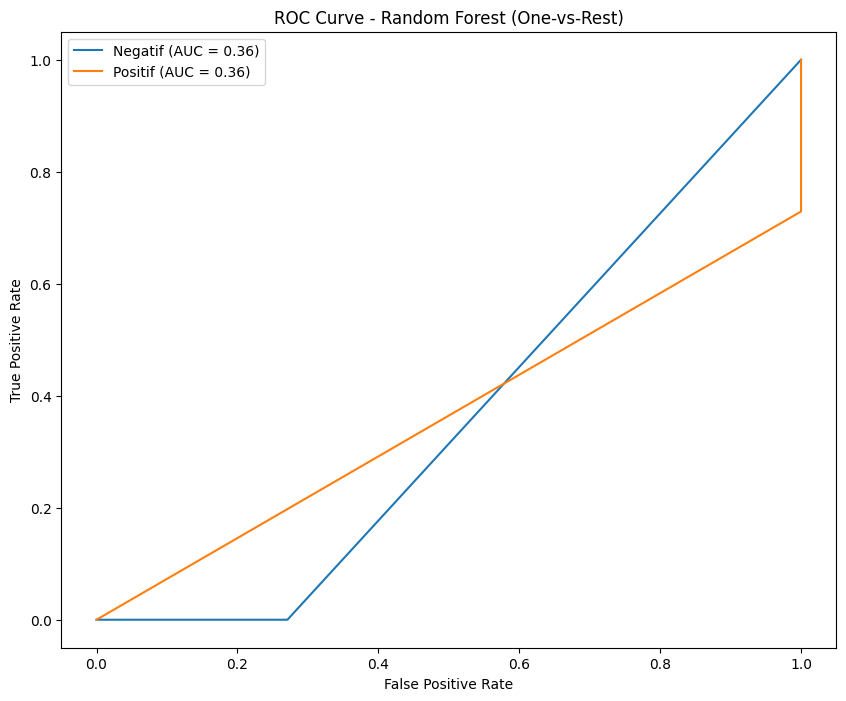

<Figure size 1300x1000 with 0 Axes>

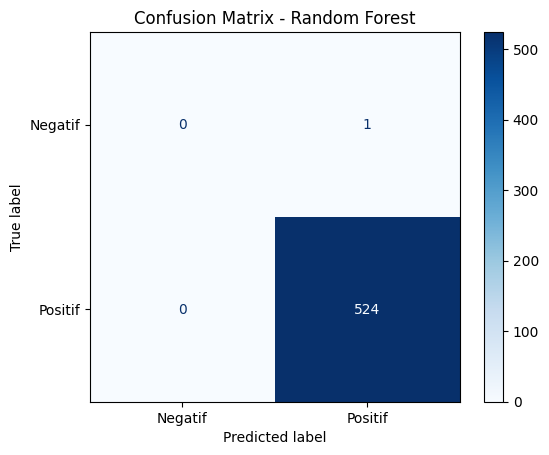


=== Logistic Regression ===

Accuracy: 1.00
Precision: 1.00
Recall: 1.00

Classification Report:
               precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         1
     Positif       1.00      1.00      1.00       524

    accuracy                           1.00       525
   macro avg       0.50      0.50      0.50       525
weighted avg       1.00      1.00      1.00       525

ROC-AUC Score: 0.74


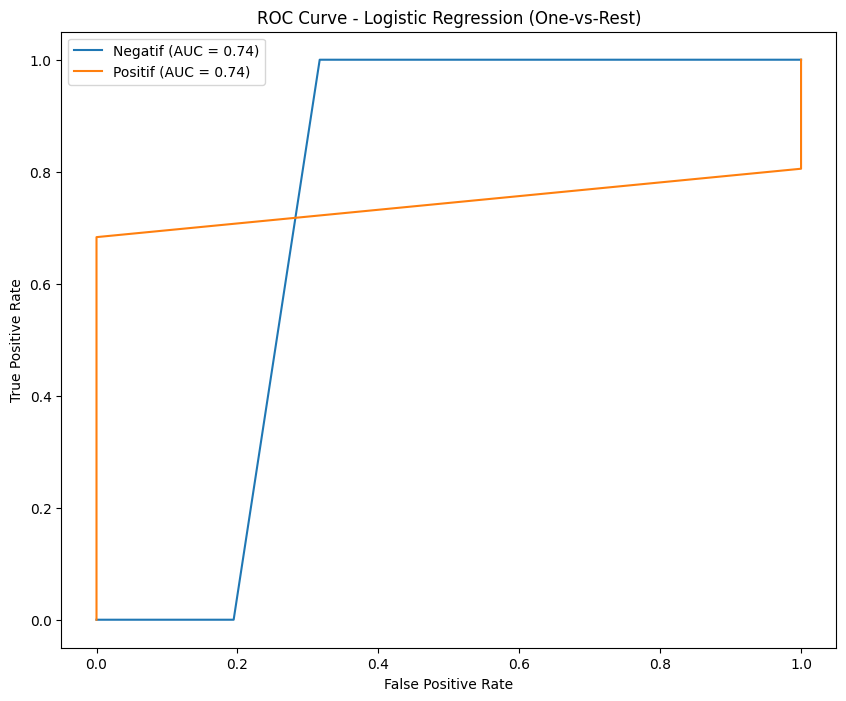

<Figure size 1300x1000 with 0 Axes>

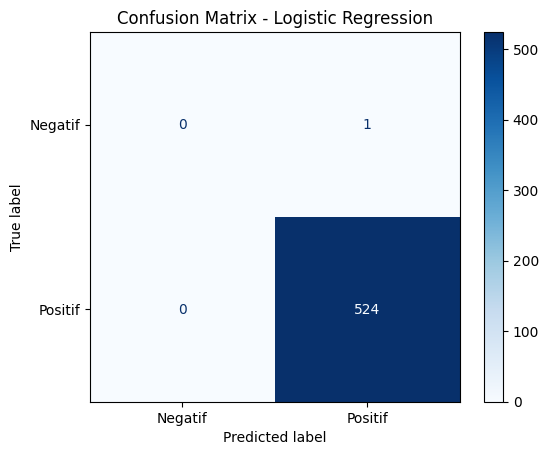


=== Support Vector Machine ===

Accuracy: 1.00
Precision: 1.00
Recall: 1.00

Classification Report:
               precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         1
     Positif       1.00      1.00      1.00       524

    accuracy                           1.00       525
   macro avg       0.50      0.50      0.50       525
weighted avg       1.00      1.00      1.00       525

ROC-AUC Score: 0.16


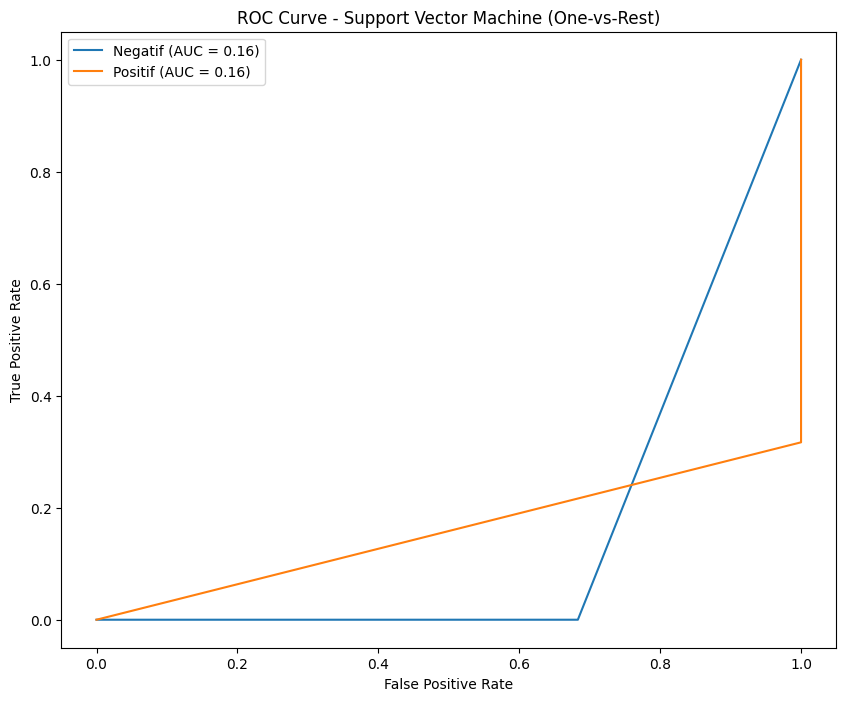

<Figure size 1300x1000 with 0 Axes>

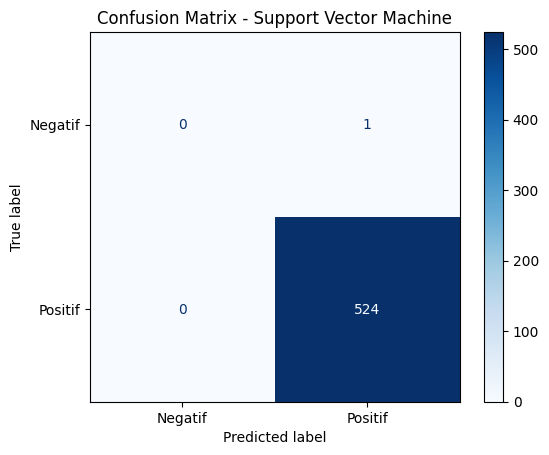

In [12]:
#Load the dataset and ensure columns are named correctly
file_path = 'Lexicon_Dataset_v3.xlsx'  
df_lexicon = pd.read_excel(file_path)
df_lexicon.columns = ['CILUBA', 'FRANCAIS', 'ENGLISH', 'SHONA', 'SePEDI', 'SeSOTHO', 'IsiZULU', 'SCORE', 'SENTIMENT', 'NATURE']

#Filter for positive scores only
df_lexicon = df_lexicon[df_lexicon['SCORE'] > 0]

#Encode 'SENTIMENT' and 'NATURE' columns
label_encoder_sentiment = LabelEncoder()
df_lexicon['SENTIMENT_encoded'] = label_encoder_sentiment.fit_transform(df_lexicon['SENTIMENT'])

label_encoder_nature = LabelEncoder()
df_lexicon['NATURE_encoded'] = label_encoder_nature.fit_transform(df_lexicon['NATURE'])

#Add a log-transformed SCORE column
df_lexicon['SCORE_log_transformation'] = np.log1p(df_lexicon['SCORE'])  # Use log1p to handle log(0) cases

#Prepare features (X) and target (y)
X = df_lexicon[['SCORE_log_transformation', 'NATURE_encoded']]
y = df_lexicon['SENTIMENT_encoded'].astype(int)  # Ensure y contains integers

#Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Define models to evaluate
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

#Loop over each model
for model_name, model in models.items():
    print(f"\n=== {model_name} ===\n")
    
    #Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None  # SVM needs `probability=True` for this
    
    #Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    
    #Classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder_sentiment.classes_))
    
    #ROC-AUC (One-vs-Rest approach for multi-class)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(pd.get_dummies(y_test), y_pred_proba, multi_class='ovr')
        print(f"ROC-AUC Score: {roc_auc:.2f}")
        
        #Plot ROC Curve for each class
        plt.figure(figsize=(10, 8))
        for i, label in enumerate(label_encoder_sentiment.classes_):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            auc_score = roc_auc_score((y_test == i).astype(int), y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
        
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name} (One-vs-Rest)")
        plt.legend()
        plt.show()
    
    #Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=label_encoder_sentiment.transform(label_encoder_sentiment.classes_))
    plt.figure(figsize=(13, 10))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_sentiment.classes_).plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

In [14]:
#lime
#Choose the Random Forest model as rf_model for LIME
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=['SCORE_log_transformation', 'NATURE_encoded'],
    class_names=label_encoder_sentiment.classes_,
    verbose=True, 
    mode='classification'
)

#Pick a single prediction to explain
i = 0  # Select the index of a test instance
exp = explainer.explain_instance(X_test[i], rf_model.predict_proba)
exp.show_in_notebook()



Intercept 0.9987268515335104
Prediction_local [0.9993495]
Right: 1.0
